In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import gdal
import os
import math
import cv2
from sklearn.mixture.gaussian_mixture import GaussianMixture

In [22]:
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.
from sklearn import metrics


def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()





In [5]:
# 读取数据
def readimg(name):
    img = gdal.Open(os.path.join(filepath, name))
    img_b = img.GetRasterBand(1).ReadAsArray()
    img_g = img.GetRasterBand(2).ReadAsArray()
    img_r = img.GetRasterBand(3).ReadAsArray()
    img_n = img.GetRasterBand(4).ReadAsArray()
    img = np.dstack((img_b,img_g,img_r,img_n))
    print(img.shape)
    width=img.shape[0]
    height=img.shape[1]
    img.resize((img.shape[0]*img.shape[1],4))
    return img

In [12]:
# 数据分布可视化
def plotDist(data,name='',range=None):
    plt.hist(data[:,2], bins=256, facecolor='r', edgecolor='r', alpha=0.2)#bins=256
    plt.hist(data[:,1], bins=256, facecolor='g', edgecolor='g', alpha=0.2)
    plt.hist(data[:,0], bins=256, facecolor='b', edgecolor='b', alpha=0.2)
    plt.title(name+" distribution")
    plt.savefig(r"E:\project\imgs\\"+name+"distribution.png",dpi=400)
    plt.show()

In [70]:
def param(X,y):
    n=np.unique(y).shape[0]
    means=np.zeros((n,3),dtype=np.float64)
    var=np.zeros((n,3),dtype=np.float64)
    X_c=[]
    for i in range(n):
        X_c.append([])
    for i in range(10000):
        X_c[y[i]].append(X[i,:])
    for i in range(n):
        a=np.array(X_c[i])
        for j in range(3):
            means[i,j]=a[:,j].mean()
            var[i,j]=a[:,j].std()
    return means,var

In [26]:
filepath = r"E:\project\images\researchImage\region"
data07 = readimg("070727.tif")
data10 = readimg("100818.tif")
data11 = readimg("110608.tif")
data13 = readimg("130916.tif")
data15 = readimg("150729.tif")
data17 = readimg("170823.tif")
data18 = readimg("181029.tif")

(5415, 5451, 4)
(5415, 5451, 4)
(5415, 5451, 4)
(5415, 5451, 4)
(5415, 5451, 4)
(5415, 5451, 4)
(5415, 5451, 4)


In [110]:
data=data10[:,:3]


In [81]:
# 采样矩阵
sample = np.random.randint(0,5400,size=[100000,2])
sample

array([[3028, 2419],
       [5272, 1599],
       [1881, 3996],
       ...,
       [1134,  543],
       [5370, 5268],
       [4891, 2095]])

In [111]:
X=[]
for _ in sample:
    X.append(data[_[0]*_[1],:])
X=np.array(X)
X.shape

(100000, 3)

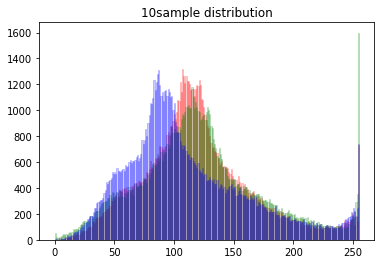

In [112]:
plotDist(X,'10sample')

In [113]:
# 衡量采样前后距离
print("before sample and after sample MMD:",mmd_linear(data,X))

before sample and after sample MMD: 294.5062241552141


In [114]:
gmm=GaussianMixture(n_components=10).fit(X)
y_pred=gmm.predict(X)

In [115]:
mean07,var07=param(X,y_pred)

In [116]:
def gd(x, mu=0, sigma=1):
    left = 1 / (np.sqrt(2 * math.pi) * np.sqrt(sigma))
    right = np.exp(-(x - mu)**2 / (2 * sigma))
    return left * right

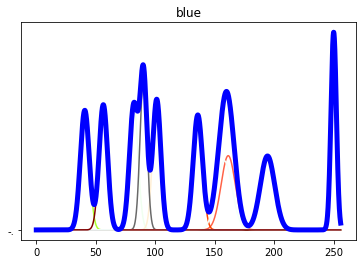

In [117]:
color=['honeydew','tomato','papayawhip','cyan','greenyellow','orangered','dimgray','lavender','mintcream','maroon']
y=np.zeros((2560,10))
for i in range(10):
    x=np.arange(0,256,0.1)
    y[:,i]=gd(x,mean07[i,0],var07[i,0])
    plt.plot(x,y[:,i],color[i],'-.')
plt.plot(x,np.sum(y,axis=1),'b',linewidth=5)
plt.title('blue')
plt.show()

In [72]:
mean07

(array([[111.07390218, 119.34630489, 138.40092824],
        [ 31.20156863,  37.72313725,  55.00078431],
        [ 70.10890395,  86.05047908, 105.85019864],
        [152.01713062, 152.17130621, 167.49892934],
        [ 96.38812785, 120.29223744, 164.23744292],
        [ 34.63920751,  60.63920751,  76.26485923]]),
 array([[26.73932838, 27.29264158, 28.40220108],
        [10.66903884, 12.81051246, 13.45292444],
        [19.00287952, 17.12297667, 18.433543  ],
        [49.57122065, 55.01150932, 54.37117162],
        [18.03370881, 21.92966099, 36.51118881],
        [13.80586257, 13.80586257, 14.36804783]]))